### Tf-idf를 사용한 분류기

In [51]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# 데이터 로드
data = pd.read_csv("news_data_ML.csv")

# 데이터 전처리 
data['tokenized_text'] = data['title'].apply(word_tokenize)

# 훈련 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(data['title'], data['category'], test_size=0.3)

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 나이브 베이즈 모델 초기화 및 훈련
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# 모델 평가
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       IT/과학       1.00      0.14      0.24        22
          경제       0.56      0.93      0.70        97
          사회       0.50      0.22      0.31        41
       생활/문화       0.69      0.36      0.47        25
          정치       0.92      0.55      0.69        22

    accuracy                           0.59       207
   macro avg       0.74      0.44      0.48       207
weighted avg       0.65      0.59      0.54       207



In [52]:
X_test

554               지난해 경제 성장률 1.4%↑…4분기 0.6% 증가
161     수출 한국 이끌던 서울 구로공단 '벌집촌', 첨단 주거단지로 변신한다
271            한국서 교육받은 31세 차관, 코소보 스포츠계를 뒤집었다
152       [단독] 3주간 아파트 공급 멈춘다…청약홈 개편에 건설사 '당혹'
81               한국주택협회 "중대재해처벌법 확대, 건설업계 삼중고"
                        ...                   
657    한국계 셀린 송 감독 ‘패스트 라이브즈’…美 아카데미 작품·각본상 후보
215                    공학한림원 대상 박남규·젊은공학인상 하정우
616                  세계적인 여행지서 한국인 귀중품 도난 '급증'
368             ‘피지컬100’ 인기, 한국서 첫 세계 피트니스 레이스
44             또 오픈런?…처칠이 즐기던 ‘커피의 에르메스’ 한국 온다
Name: title, Length: 207, dtype: object

#### example_text에 원하는 제목을 입력해 예측 결과 확인

In [53]:
example_text = "EU, 반도체·AI 등 민감기술 투자·수출 통제 추진"

# 전체 텍스트에 대한 벡터 변환
example_text_vec = vectorizer.transform([example_text])  # 리스트로 감싸서 전달

# 예측 수행
predicted_category = model.predict(example_text_vec)

print(f"제목: {example_text} \n예측된 카테고리: {predicted_category[0]}")

제목: EU, 반도체·AI 등 민감기술 투자·수출 통제 추진 
예측된 카테고리: 경제


Multinomial Naive Bayes 모델은 각 클래스에 대한 각 단어의 로그 조건부 확률을 feature_log_prob_ 속성에 저장한다.  
이 값을 사용하여 각 클래스에 대한 가장 중요한 단어들을 확인해보자.

In [54]:
import numpy as np

# TF-IDF 벡터라이저의 특성 이름 가져오기
feature_names = vectorizer.get_feature_names_out()

# 각 클래스에 대한 상위 N개 중요 단어를 추출하는 함수
def top_n_words_per_class(class_index, n=10):
    sorted_indices = model.feature_log_prob_[class_index, :].argsort()[::-1]
    top_n = feature_names[sorted_indices][:n]
    return top_n

# 각 클래스에 대한 상위 단어들 출력
for i in range(len(model.classes_)):
    class_name = model.classes_[i]
    top_words = top_n_words_per_class(i, 10)
    print(f"Class: {class_name}")
    print(f"Top words: {', '.join(top_words)}\n")


Class: IT/과학
Top words: 교수, 박남규, 한국공학한림원, 한국고용정보원, 개인정보, 유출, 과태료, 대상, 한국오라클, 클라우드

Class: 경제
Top words: 한국, 경제, 지난해, 성장, 정은보, 한국거래소, 인사, 이사장, 회장, 한국가스안전공사

Class: 사회
Top words: 한국, 강원2024, 안전한국훈련, 산림청, 최우수, 재난대응, 한국가스안전공사, 한국인, 인사, 중국

Class: 생활/문화
Top words: 한국, 한국계, 후보, 셀린, 감독, 한국타이어, 라이브즈, 패스트, 아카데미, 공개

Class: 정치
Top words: 합당, 양향자, 이준석, 한국의희망, 개혁신당, 선언, 한국, 재외공관, 오해, 초래



In [55]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# 데이터 로드 및 전처리
data = pd.read_csv("news_data_ML.csv")

# 파이프라인 생성: TF-IDF 벡터화 및 나이브 베이즈 모델
pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())

# 교차 검증 수행
cross_val_scores = cross_val_score(pipeline, data['title'], data['category'], cv=10, scoring='accuracy')

# 교차 검증 결과 출력
print("교차 검증 정확도 점수:", cross_val_scores)
print("평균 정확도:", np.mean(cross_val_scores))


교차 검증 정확도 점수: [0.57971014 0.62318841 0.60869565 0.5942029  0.60869565 0.60869565
 0.5942029  0.60294118 0.5        0.47058824]
평균 정확도: 0.5790920716112533


### Word2Vec를 사용한 분류기

In [56]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 데이터 로드 및 전처리
data = pd.read_csv("news_data_ML.csv")

data['tokenized_text'] = data['title'].apply(word_tokenize)
# Word2Vec 모델 훈련
w2v_model = Word2Vec(data['tokenized_text'], vector_size=100, window=5, min_count=1, workers=4)

# 문서별 평균 벡터 계산 함수
def document_vector(doc):
    # 단어 벡터의 평균을 계산
    doc = [word for word in doc if word in w2v_model.wv.index_to_key]
    return np.mean(w2v_model.wv[doc], axis=0)

# 각 문서에 대한 문서 벡터 생성
data['doc_vector'] = data['tokenized_text'].apply(document_vector)

# 훈련 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(data['doc_vector'].tolist(), data['category'], test_size=0.3)

# 분류기 훈련
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# 예측을 위한 함수 정의
def predict_category(text, w2v_model, classifier):
    # 텍스트를 토큰화하고 Word2Vec 모델을 사용하여 벡터 생성
    tokenized_text = text.split()
    doc_vector = document_vector(tokenized_text)
    if np.isnan(doc_vector).any():
        doc_vector = np.zeros(w2v_model.vector_size)
    
    # 예측 수행
    predicted_category = classifier.predict([doc_vector])
    return predicted_category[0]

# 모델 평가
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       1.00      0.17      0.29        18
          경제       0.58      0.93      0.72        97
          사회       0.56      0.45      0.50        42
       생활/문화       0.83      0.18      0.29        28
          정치       0.90      0.41      0.56        22

    accuracy                           0.61       207
   macro avg       0.78      0.43      0.47       207
weighted avg       0.68      0.61      0.56       207



Word2Vec 모델은 훈련 데이터에 있는 단어들만 학습한다. 만약 예측하려는 텍스트에 훈련 데이터에 없는 새로운 단어가 포함되어 있다면, 이 단어들은 Word2Vec 모델에 의해 벡터로 변환되지 않기 때문에, 제대로 예측하지 못하거나 에러가 나온다.
즉 뉴스 제목으로 카테고리를 예측하는 모델을 만들 때 Word2Vec 모델을 사용한다면, 뉴스 제목에 어떤 단어가 들어와도 그 단어가 훈련 데이터 안에 있어야 하도록 어마어마한 양의 훈련 데이터가 필요하다는 뜻이다.

In [57]:
#제목에 있는 단어가 학습 데이터에 모두 있는 경우
example_text_1 = "24개국, 미·영 후티 추가공습 지지 성명…한국도 포함"
predicted_category_1 = predict_category(example_text_1, w2v_model, classifier)
print(f"제목: {example_text_1} \n예측된 카테고리: {predicted_category_1}")

# #제목에 학습 데이터에 없는 단어가 있는 경우 - ValueError: need at least one array to concatenate
# example_text_2 = "한국원자력학회, 고준위 방폐물 특별법 처리 촉구"
# predicted_category_2 = predict_category(example_text_2, w2v_model, classifier)
# print(f"제목: {example_text_2} \n예측된 카테고리: {predicted_category_2}")

제목: 24개국, 미·영 후티 추가공습 지지 성명…한국도 포함 
예측된 카테고리: 사회


Word2Vec에서 각 특성은 Word2Vec 모델에 의해 생성된 개별 차원(word -> vector)을 나타내기 때문에, 카테고리 결정에 영향을 미치는 구체적인 단어를 파악하고자 한다면 TF-IDF를 사용해야 한다.

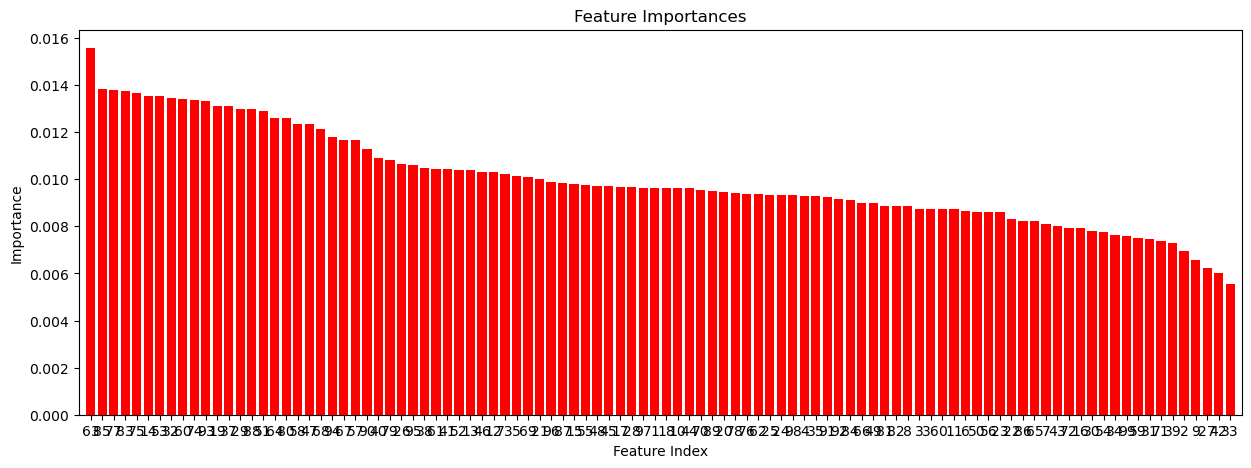

In [58]:
import matplotlib.pyplot as plt

# RandomForestClassifier의 feature importance 추출
importances = classifier.feature_importances_

# feature importance를 시각화
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(15, 5))
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), indices)
plt.xlim([-1, len(indices)])
plt.xlabel('Feature Index') #xlabel 이 단어가 아닌 벡터로 나온다.
plt.ylabel('Importance')
plt.show()

In [59]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

#전체 문서 벡터를 NumPy 배열로 변환
X = np.array(data['doc_vector'].tolist())
y = data['category']

# RandomForestClassifier 초기화
classifier = RandomForestClassifier()

# 교차 검증 실행 (예: 5-폴드 교차 검증)
scores = cross_val_score(classifier, X, y, cv=10)

# 평균 정확도 출력
print("교차 검증 정확도:", scores)
print("평균 정확도:", np.mean(scores))

교차 검증 정확도: [0.57971014 0.63768116 0.5942029  0.50724638 0.57971014 0.5942029
 0.49275362 0.45588235 0.52941176 0.47058824]
평균 정확도: 0.5441389599317988
